<a href="https://www.kaggle.com/code/amirhosseinzinati/animal10-with-resnet50-in-pytorch?scriptVersionId=148255337" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Resnet50

## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import glob 
import random
from PIL import Image
from tqdm import tqdm

In [2]:
ngpu = 2                    # Number of GPUs available. Use 0 for CPU mode.
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

## Dataset

### Animals-10

this dataset  contains about 28K medium quality animal images belonging to 10 categories:
 dog, cat, horse, spyder, butterfly, chicken, sheep, cow, squirrel, elephant
 All the images have been collected from "google images" and have been checked by human. There is some erroneous data to simulate real conditions

## Loding Data

In [3]:
classes = { "cane": "dog",
            "cavallo": "horse",
            "elefante": "elephant",
            "farfalla": "butterfly",
            "gallina": "chicken", 
            "gatto": "cat",
            "mucca": "cow",
            "pecora": "sheep",
            "scoiattolo": "squirrel",
            "dog": "cane", 
            "cavallo": "horse",
            "elephant" : "elefante",
            "butterfly": "farfalla",
            "chicken": "gallina",
            "cat": "gatto", 
            "cow": "mucca",
            "spider": "ragno",
            "squirrel": "scoiattolo"}
data = {
    "path":[],
    "label":[]
}
data_dir="/kaggle/input/animals10/raw-img"

### Show Some Sample of Dataset

In [4]:
for label_it,label_en in classes.items():
    paths = glob.glob(f'{data_dir}/{label_it}/*.jpeg')

    data["path"].extend(paths)
    data["label"].extend([label_en] * len(paths))

df_data = pd.DataFrame(data)
df_data.head()

,path,label
0,/kaggle/input/animals10/raw-img/cane/OIP-6p-HH...,dog
1,/kaggle/input/animals10/raw-img/cane/OIP-A1GkR...,dog
2,/kaggle/input/animals10/raw-img/cane/OIP-GZmwq...,dog
3,/kaggle/input/animals10/raw-img/cane/OIP-Yj0uE...,dog
4,/kaggle/input/animals10/raw-img/cane/OIP-bbrbp...,dog


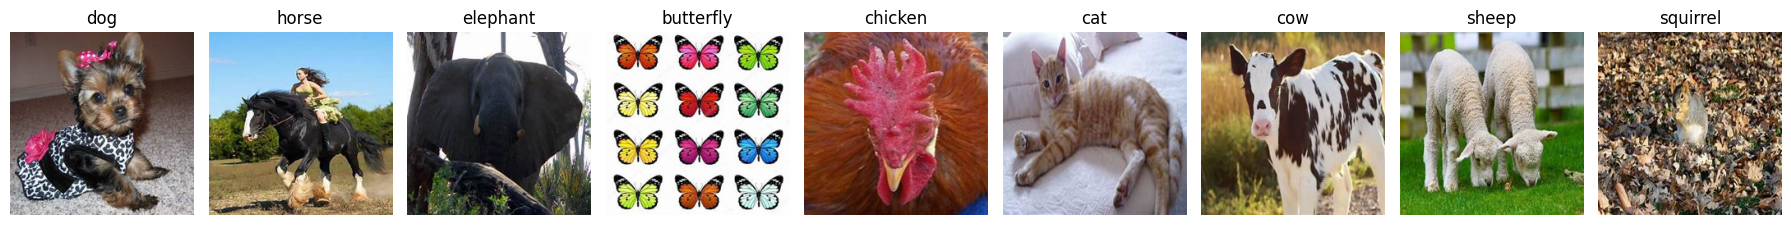

In [5]:
plt.figure(figsize = (20, 7))

for idx, i in enumerate(df_data.label.unique()):
    plt.subplot(1, 10, idx + 1)
    df = df_data[df_data['label'] == i].reset_index(drop=True)
    
    image_path = df.loc[random.randint(0, len(df) - 1), 'path']
    img = Image.open(image_path)
    img = img.resize((224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    
plt.tight_layout()
plt.show()

### Preper Dataset for Pytorch

In [6]:
transform = transforms.Compose([
     transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
Dataset = datasets.ImageFolder(root=data_dir, transform=transform)
# Print the number of classes
num_classes = len(Dataset.classes)
print(f"Number of classes: {num_classes}")

# Print the number of samples
num_samples = len(Dataset)
print(f"Number of samples: {num_samples}")

Number of classes: 10
Number of samples: 26179


In [8]:
train_size = int(0.8 * len(Dataset))  # 80% for training
test_size = len(Dataset) - train_size  # 20% for testing
# split dataset
train_dataset, test_dataset = random_split(Dataset, [train_size, test_size])

# Create data loaders for the train and test datasets
batch_size = 32  # You can adjust this value as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## ResNet

ResNet-50 is a convolutional neural network that is 50 layers deep. ResNet, short for Residual Networks is a classic neural network used as a backbone for many computer vision tasks. The fundamental breakthrough with ResNet was it allowed us to train extremely deep neural networks with 150+layers. It is an innovative neural network that was first introduced by __Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun__ in their 2015 computer vision research paper titled ‘__Deep Residual Learning for Image Recognition__’.

Convolutional Neural Networks have a major disadvantage — ‘__Vanishing Gradient__ Problem’. During backpropagation, the value of gradient decreases significantly, thus hardly any change comes to weights. To overcome this, ResNet is used. It make use of “__SKIP CONNECTION__”.

__SKIP CONNECTION__ is a direct connection that skips over some layers of the model. The output is not the same due to this skip connection. Without the skip connection, input ‘X gets multiplied by the weights of the layer followed by adding a bias term.

### ResNet Architectures

The commonly used ResNet architectures include ResNet18, ResNet-34, ResNet-50, ResNet-101, and ResNet-152, each of which has different residual block structure and different number of residual blocks

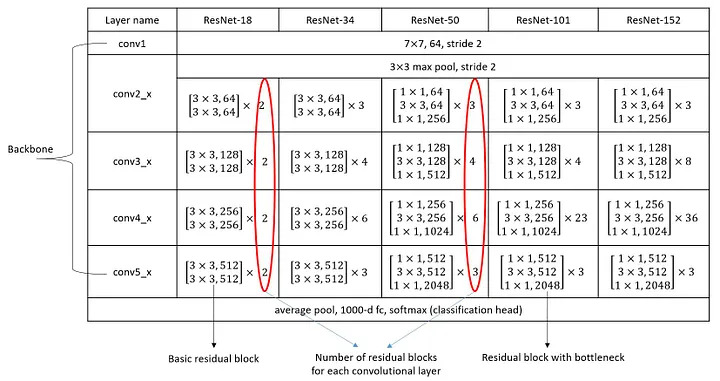

each of five ResNet architectures consists of five convolutional layers (conv1, conv2_x — conv5_x), an average pooling layer, a fully connected layer and softmax. The five convolutional layers are the backbone network.

The backbone networks of ResNet, pretrained using ImageNet, are widely used to extract features at different levels of resolution (feature maps after conv2_x, conv3_x, conv4_x, and conv5_x). Those features are followed by particular neck and heads and fine-tuned for particular tasks, like object detection, semantic segmentation, etc.

The five ResNet architectures use the residual block as the basic building block. Each of the convolutional layers from conv2_x to conv5_x uses different number of the residual blocks. For examples, as indicated by the red ellipses upper figure, in ResNet-18, the number of the residual blocks used in conv2_x, conv3_x, conv4_x conv5_x is 2, 2, 2 and 2, respectively. In ResNet-50, the number of the residual blocks used in conv2_x, conv3_x, conv4_x conv5_x is 3, 4, 6 and 3, respectively.

The structure of the residual block used by ResNet-18 and ResNet-34 is different from the one used by ResNet-50, ResNet-101, and ResNet-152, as shown in bellow. Starting from ResNet-50, the bottleneck structure is used to reduce the model parameters by alternating 1x1 and 3x3 convolutions. As shown in bellow, compared to two convolutions of 3x3, 64 and 3x3, 256, the number of model parameters are reduced from 294912 to 69632. Another advantage of the bottleneck structure is that more activations are introduced due to more convolutions. Accordingly, the nonlinearity and model capacity is increased.

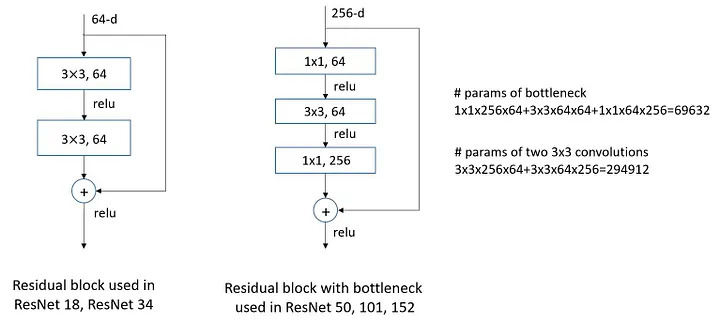

ResNet extracts features at decreasing levels of resolution from conv2_x to conv5_x. In particular, s2 (stride=2) is used in the first 3x3 convolutions of the first residual blocks for conv3_x, conv4_x, and conv5_x to downsample feature maps to get larger receptive field. Therefore, special care is given to those residual blocks to match spatial dimension of feature maps and number of channels in order to perform the add operations for the skip connections.

Bellow figure shows the skip connections go through 1x1 convolutions with s2 in the first residual blocks of conv3_x layers used in ResNet 18, 34, and ResNet 50, 101, 152, respectively, to match spatial dimension of feature maps and number of channels for the add operations of the skip connections.

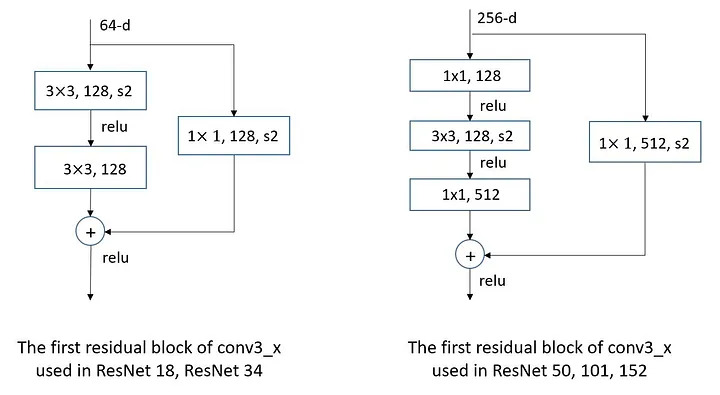

### Residual Block

Before starting with the network, we need to build a ResidualBlock that we can re-use through out the network. The block (as shown in the architecture) contains a skip connection that is an optional parameter ( <code>downsample</code> ). Note that in the <code>forward</code>  , this is applied directly to the input,<code>x</code> , and not to the output,<code>out</code> .

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

Now, that we have created the ResidualBlock, we can build our ResNet.

Note that there are three blocks in the architecture, containing 3, 3, 6, and 3 layers respectively. To make this block, we create a helper function <code>_make_layer</code> . The function adds the layers one by one along with the Residual Block. After the blocks, we add the average pooling and the final linear layer.

In [10]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

### Setting Hyperparameters
It is always recommended to try out different values for various hyperparameters in our model, but here we will be using only one setting. Regardless, we recommend everyone try out different ones and see which works best. The hyper-parameters include defining the number of epochs, batch size, learning rate, loss function along with the optimizer. As we are building the 34 layer variant of ResNet, we need to pass the appropriate number of layers as well:

In [11]:
num_classes = 10
num_epochs = 20
batch_size = 64
learning_rate = 0.01

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    model = nn.DataParallel(model, list(range(ngpu)))
    
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

# Train the model
total_step = len(train_loader)

### Training


Now, our model is ready for training, but first we need to know how model training works in PyTorch:

* We start by loading the images in batches using our <code>train_loader</code> for every epoch, and also move the data to the GPU using the device variable we defined earlier

* The model is then used to predict on the labels, <code>model(images)</code>, and then we calculate the loss between the predictions and the ground truth using the loss function defined above, <code>criterion(outputs, labels)</code>

* Now the learning part comes, we use the loss to backpropagate method, <code>loss.backward()</code>, and update the weights, <code>optimizer.step()</code>. One important thing that is required before every update is to set the gradients to zero using <code>optimizer.zero_grad()</code> because otherwise the gradients are accumulated (default behaviour in PyTorch)

* Lastly, after every epoch, we test our model on the validation set, but, as we don't need gradients when evaluating, we can turn it off using with <code>torch.no_grad()</code>  to make the evaluation much faster.

In [12]:
import gc
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print ('Epoch [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 

Epoch [1/20], Loss: 1.6870
Accuracy of the network on the 5000 validation images: 41.95951107715813 %
Epoch [2/20], Loss: 1.9858
Accuracy of the network on the 5000 validation images: 49.5607333842628 %
Epoch [3/20], Loss: 1.2830
Accuracy of the network on the 5000 validation images: 61.80290297937357 %
Epoch [4/20], Loss: 0.8838
Accuracy of the network on the 5000 validation images: 65.46982429335371 %
Epoch [5/20], Loss: 0.9023
Accuracy of the network on the 5000 validation images: 69.11764705882354 %
Epoch [6/20], Loss: 0.7867
Accuracy of the network on the 5000 validation images: 71.1038961038961 %
Epoch [7/20], Loss: 0.8163
Accuracy of the network on the 5000 validation images: 73.85408708938121 %
Epoch [8/20], Loss: 0.9308
Accuracy of the network on the 5000 validation images: 75.45836516424751 %
Epoch [9/20], Loss: 0.9254
Accuracy of the network on the 5000 validation images: 76.71886936592819 %
Epoch [10/20], Loss: 0.4384
Accuracy of the network on the 5000 validation images: 7

### Testing

For testing, we use exactly the same code as validation but with the <code>test_loader</code>:

In [13]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))   

Accuracy of the network on the 10000 test images: 78.09396485867074 %


In [14]:
# Choose a subset of the testing dataset
num_images_to_show = 50
subset_indices = range(num_images_to_show)

In [15]:
# Classes
newClass = ["dog", 
           "horse", 
           "elephant", 
           "butterfly", 
           "chicken", 
           "cat", 
           "cow", 
           "sheep", 
           "squirrel", 
           "cane", 
           "horse", 
           "elefante",
           "farfalla", 
           "gallina", 
           "gatto",
           "mucca",
           "ragno",
           "scoiattolo"]


23it [00:04,  5.74it/s]


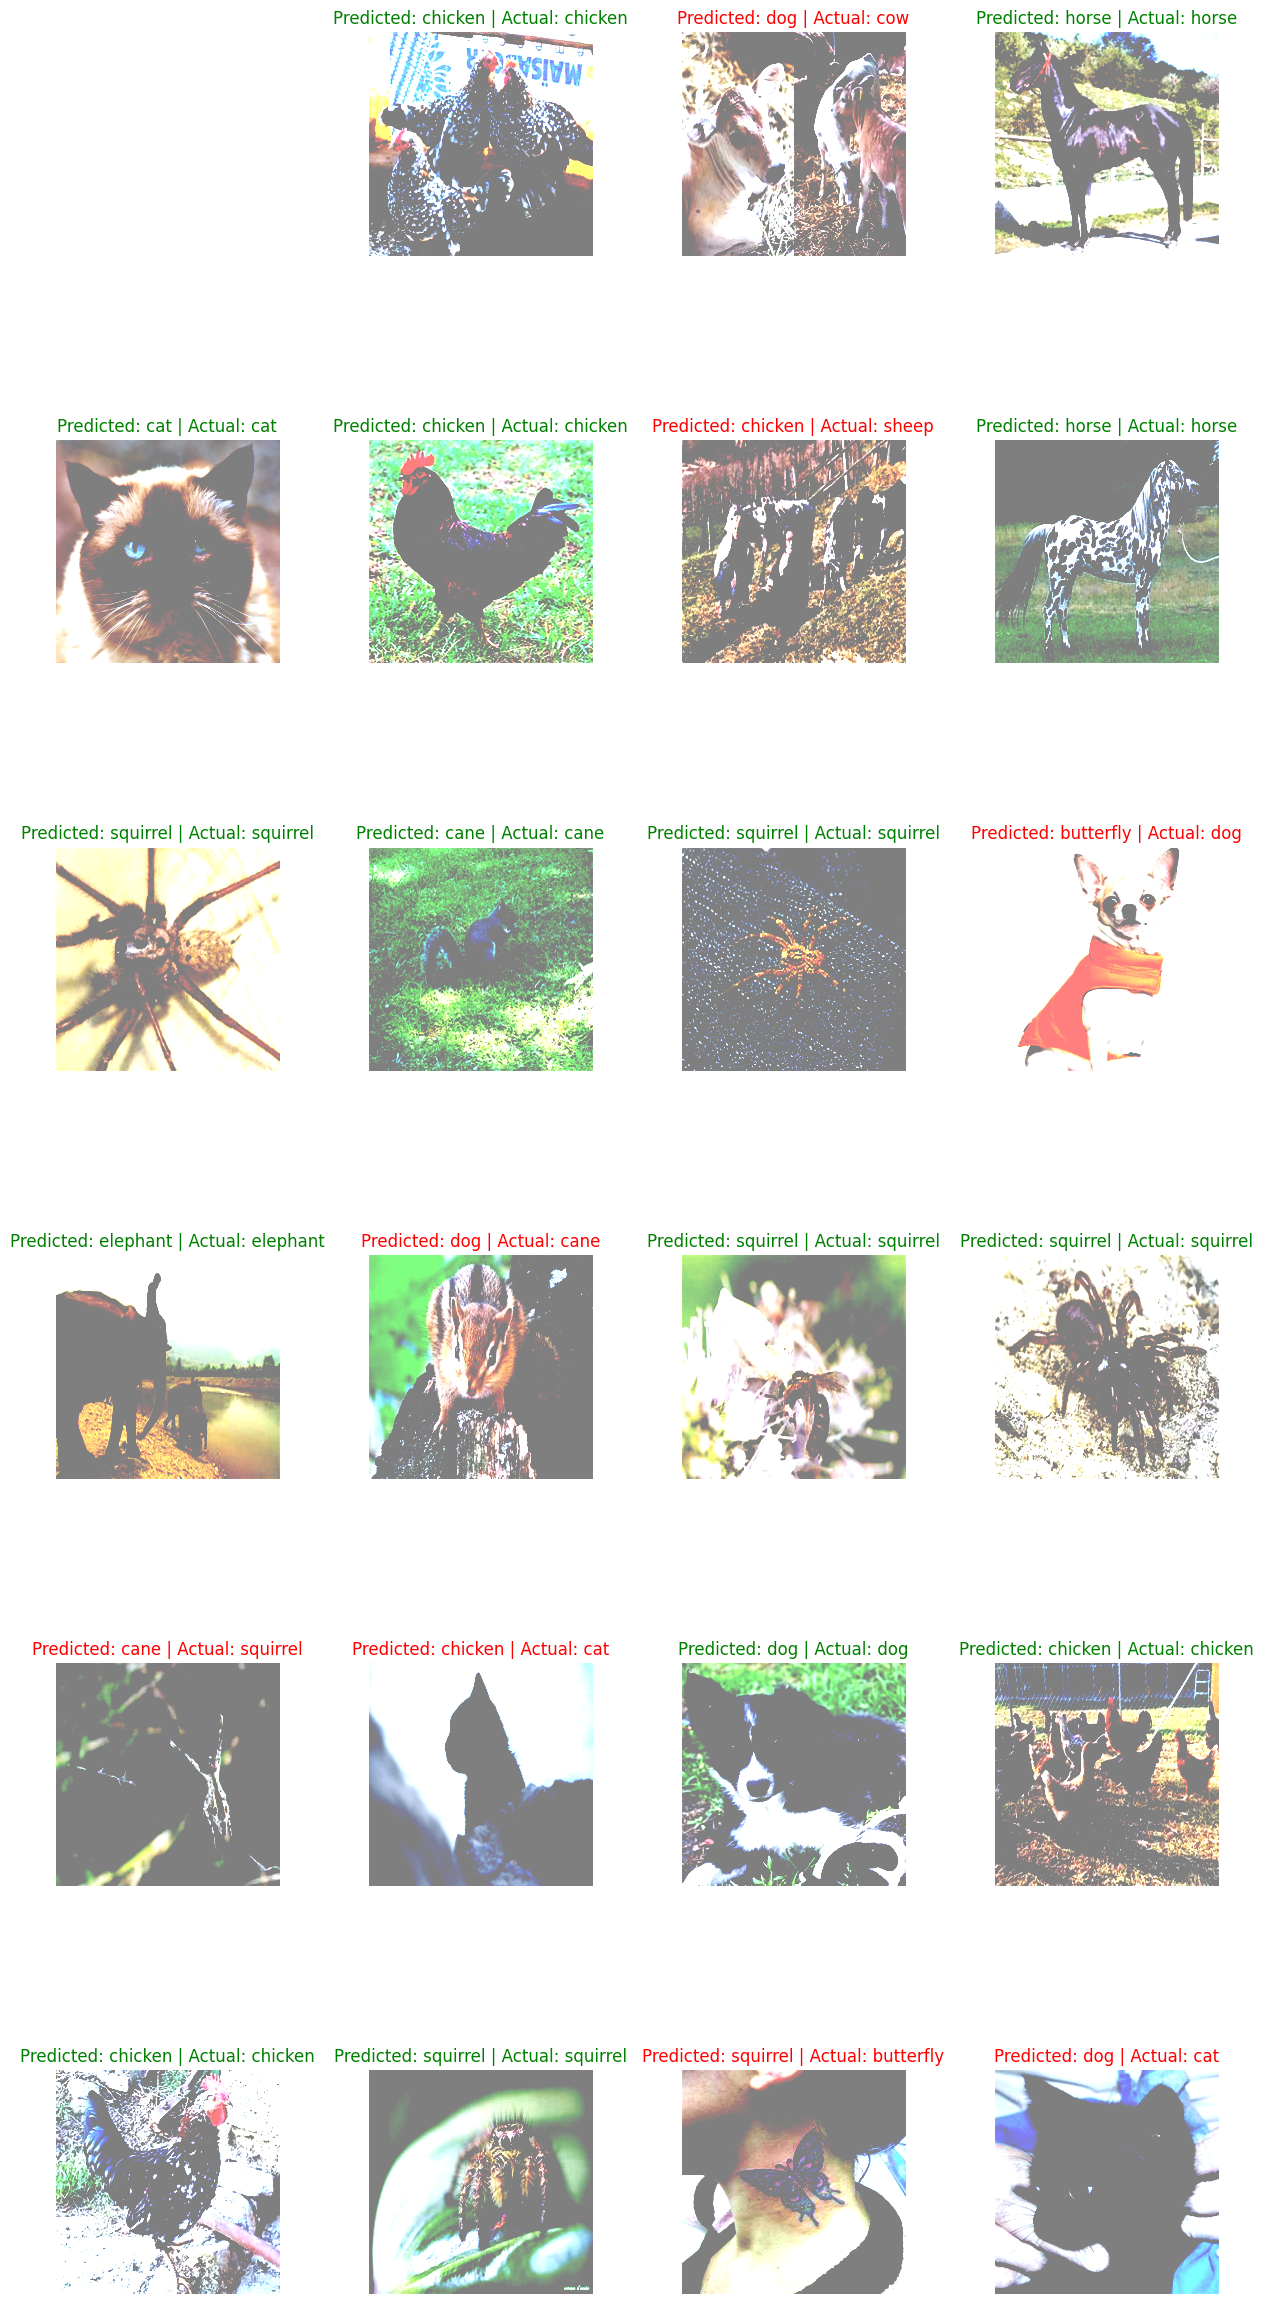

In [16]:

# Make predictions and plot images with predicted labels
plt.figure(figsize=(15, 30))
for i, (image, label) in tqdm(enumerate(test_loader, 1)):
    if i >= 24:
        break
        
    with torch.no_grad():
        images = image.to(device)
        labels = label.to(device)
        output =  model(images)
        _, predicted = torch.max(output.data, 1)
        
        plt.subplot(6, 4, i+1)
        
        # Ensure pixel values are in the [0, 1] range
        image = torch.clamp(image, 0, 1)
        plt.imshow((image[0] * 0.5 + 0.5).permute(1, 2, 0))
        if(newClass[predicted[0]]==newClass[label[0]]):
            plt.title(f'Predicted: {newClass[predicted[0]]} | Actual: {newClass[label[0]]}',color="green")
        else:
            plt.title(f'Predicted: {newClass[predicted[0]]} | Actual: {newClass[label[0]]}',color="red")
       
        plt.axis('off')
    
        if i >= num_images_to_show:
            break

plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.show()